In [1]:
!pip install pandas numpy matplotlib seaborn scipy

Looking in indexes: https://pypi.org/simple, https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


# Exploratory Data Analysis

Data source: AirQualityUCI.csv
DATASET OVERVIEW
Shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Data types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Temporal range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Duration: 389 days

MISSING VALUE ANALYSIS
               Count  Percentage
NMHC(GT)        8443       90.23
CO(GT)          1683       17.99
NO2(GT)         1642       17.55
NOx(GT)         1639       17.52
PT08.S1(CO)      366        3.91
PT08.S2(NMHC)    366        3.91
C6H6(GT)         36

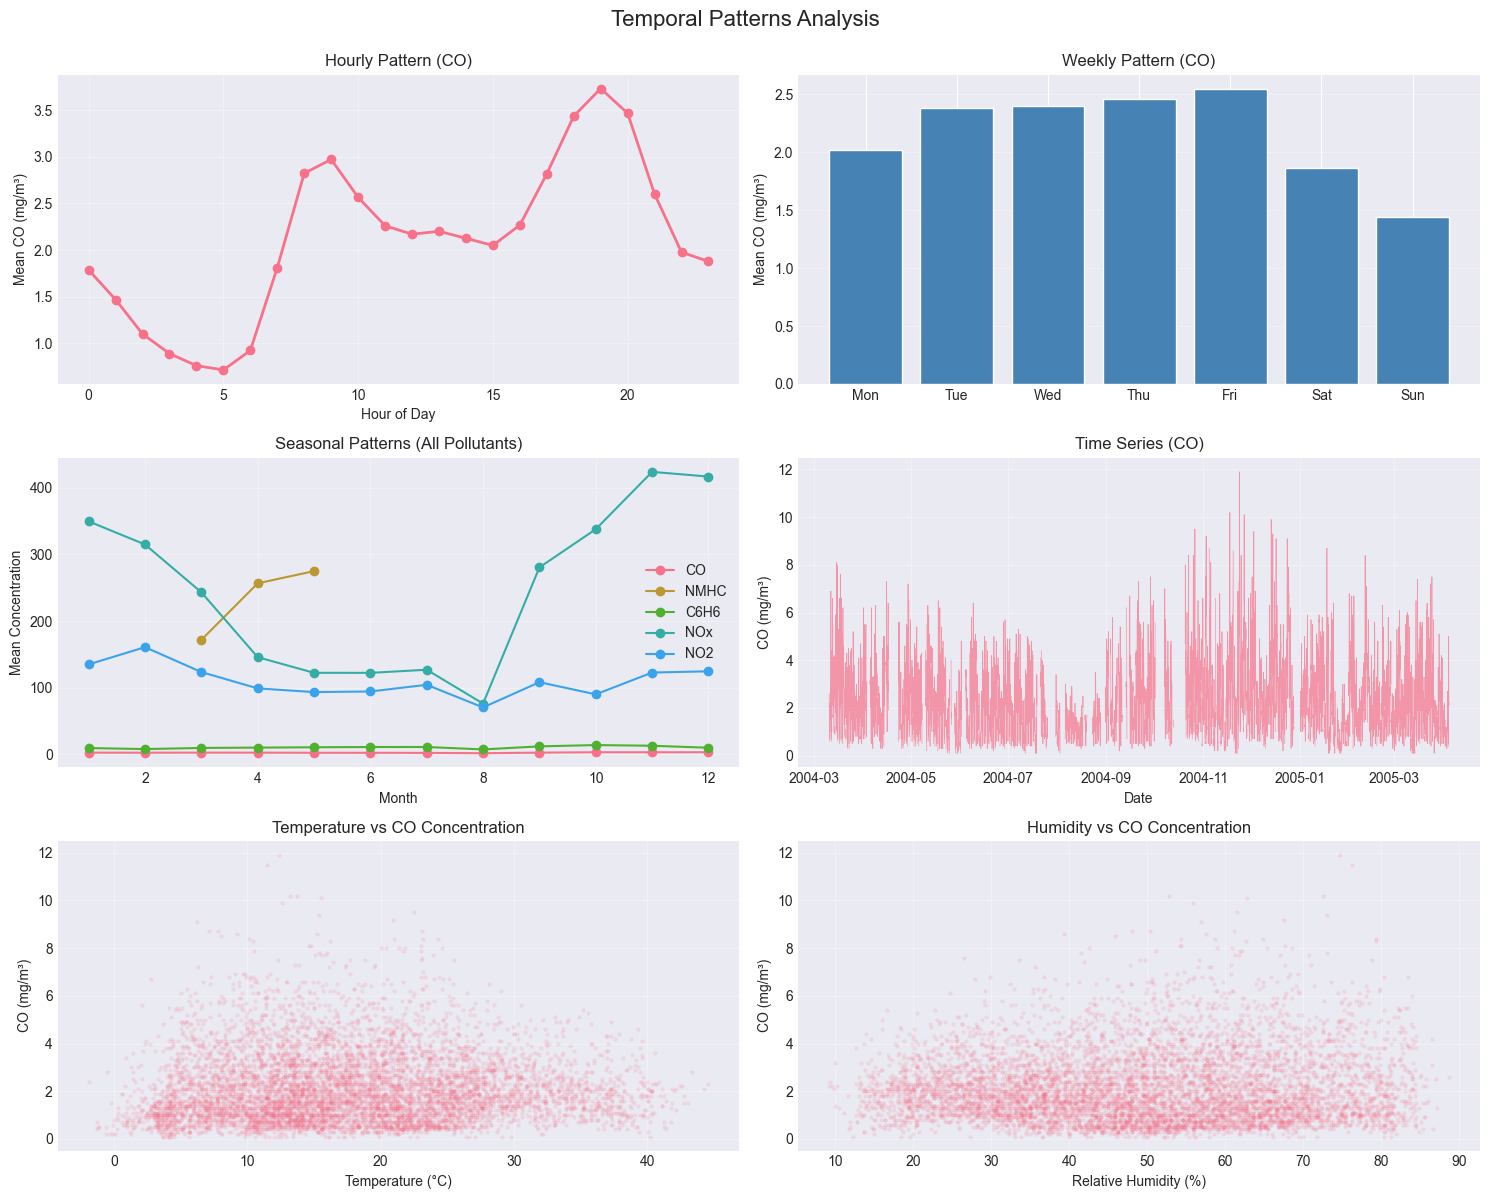

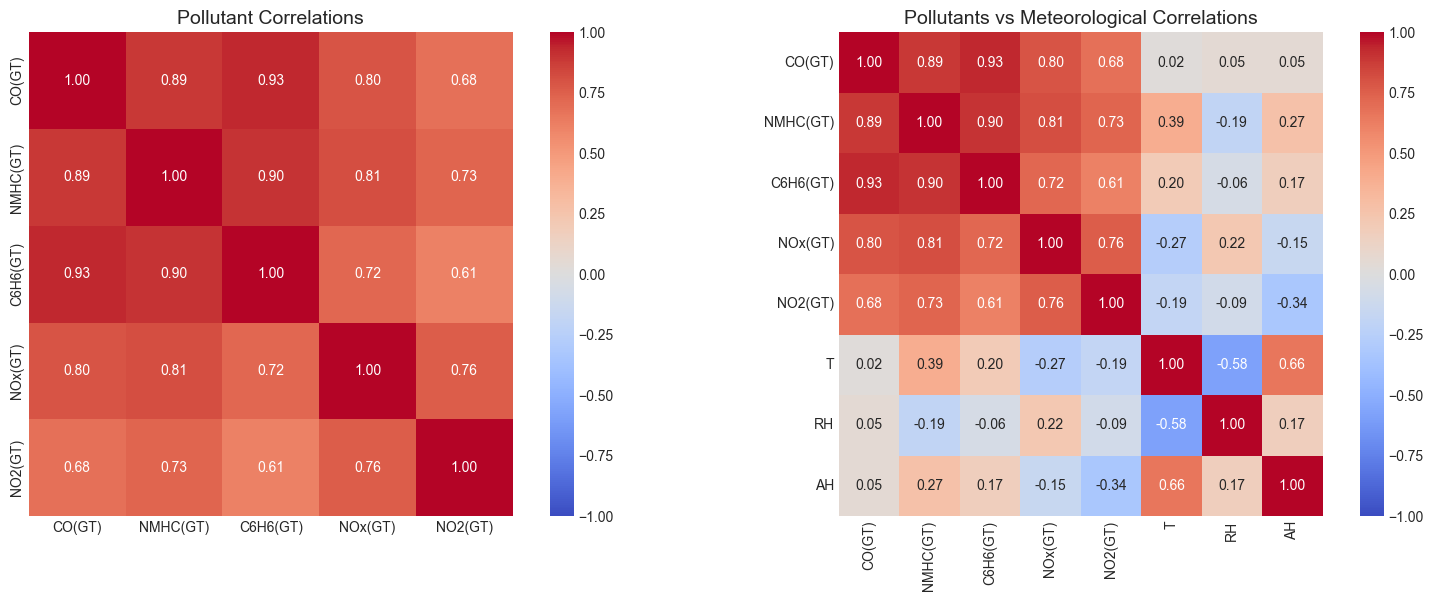

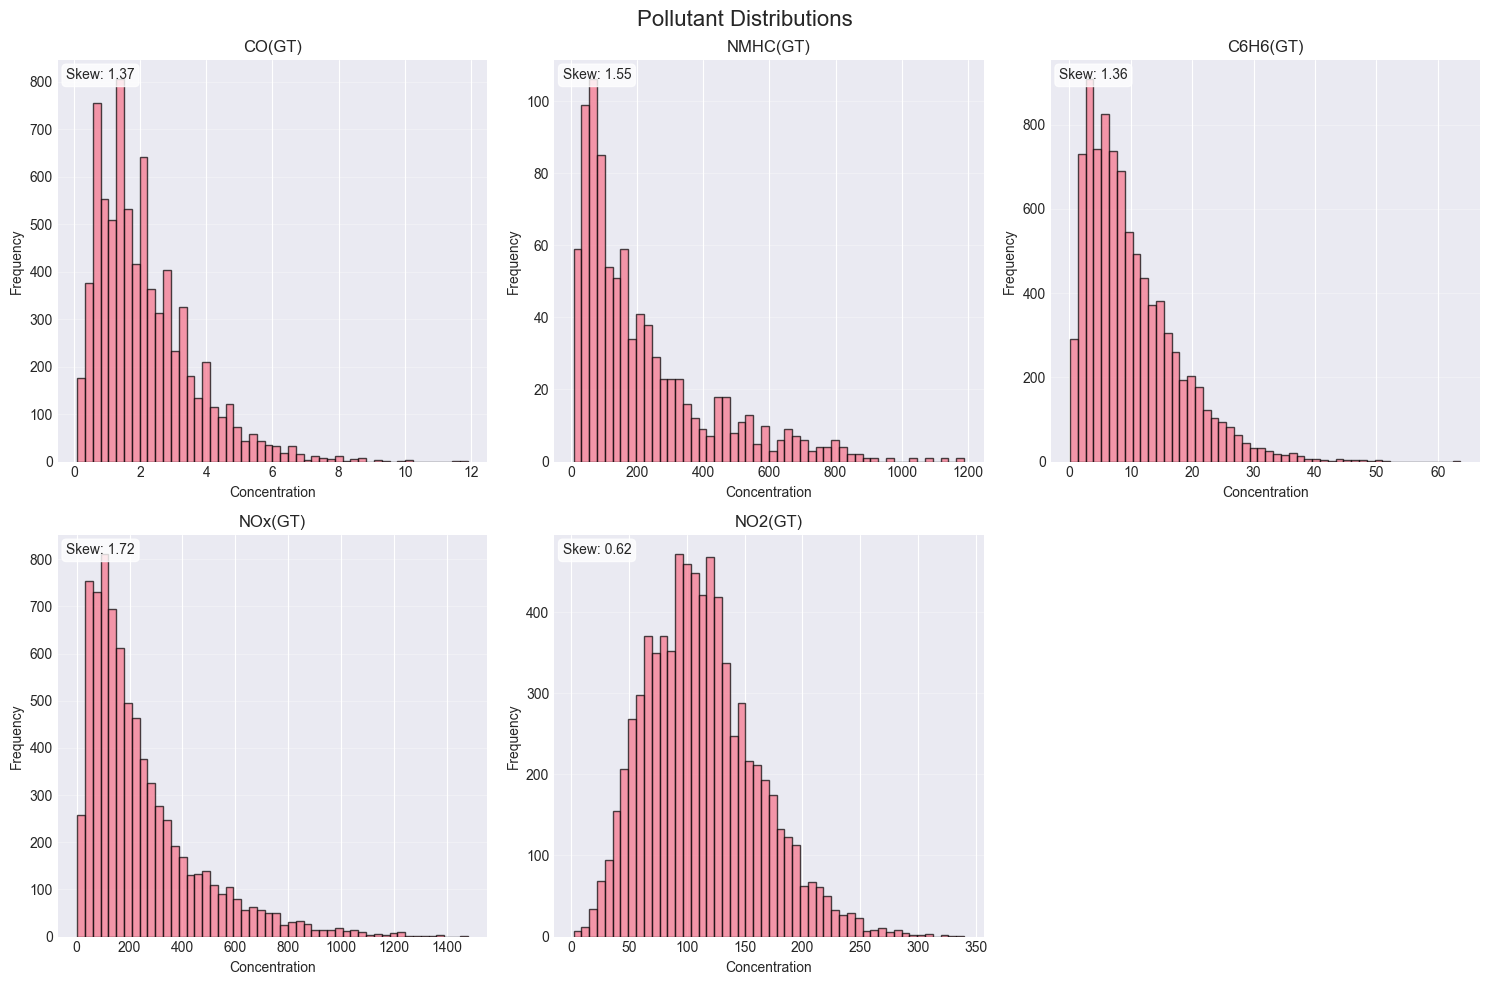

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for figures
output_dir = 'eda_figures'
os.makedirs(output_dir, exist_ok=True)

# Load data
# Try XLSX first (cleaner), fallback to CSV
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("Data source: AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("Data source: AirQualityUCI.csv")

# Remove unnamed/empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# ============================================
# 1. INITIAL DATA INSPECTION
# ============================================
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# ============================================
# 2. TEMPORAL PREPROCESSING
# ============================================
# Merge Date and Time into unified timestamp
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                 format='%d/%m/%Y %H.%M.%S',
                                 errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

# Extract temporal features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year

print(f"\nTemporal range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

# ============================================
# 3. MISSING VALUE ANALYSIS
# ============================================
# Replace sentinel value -200 with NaN
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].replace(-200.0, np.nan)

print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
missing_summary = pd.DataFrame({
    'Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Count'] > 0].sort_values('Count', ascending=False)
print(missing_summary)

# ============================================
# 4. DESCRIPTIVE STATISTICS
# ============================================
pollutants = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print("\n" + "="*60)
print("POLLUTANT STATISTICS")
print("="*60)
print(df[pollutants].describe().round(3))

# ============================================
# 5. TEMPORAL PATTERNS
# ============================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Temporal Patterns Analysis', fontsize=16, y=0.995)

# Hourly pattern
hourly_mean = df.groupby('Hour')['CO(GT)'].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean CO (mg/m³)')
axes[0, 0].set_title('Hourly Pattern (CO)')
axes[0, 0].grid(True, alpha=0.3)

# Weekly pattern
weekly_mean = df.groupby('DayOfWeek')['CO(GT)'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), weekly_mean.values, color='steelblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Mean CO (mg/m³)')
axes[0, 1].set_title('Weekly Pattern (CO)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern for all pollutants
for i, pollutant in enumerate(pollutants):
    monthly_mean = df.groupby('Month')[pollutant].mean()
    if i == 0:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
    else:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Concentration')
axes[1, 0].set_title('Seasonal Patterns (All Pollutants)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series plot
axes[1, 1].plot(df.index, df['CO(GT)'], linewidth=0.5, alpha=0.7)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('CO (mg/m³)')
axes[1, 1].set_title('Time Series (CO)')
axes[1, 1].grid(True, alpha=0.3)

# Temperature vs CO
axes[2, 0].scatter(df['T'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 0].set_xlabel('Temperature (°C)')
axes[2, 0].set_ylabel('CO (mg/m³)')
axes[2, 0].set_title('Temperature vs CO Concentration')
axes[2, 0].grid(True, alpha=0.3)

# Humidity vs CO
axes[2, 1].scatter(df['RH'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 1].set_xlabel('Relative Humidity (%)')
axes[2, 1].set_ylabel('CO (mg/m³)')
axes[2, 1].set_title('Humidity vs CO Concentration')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'temporal_patterns.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/temporal_patterns.png")

# ============================================
# 6. CORRELATION ANALYSIS
# ============================================
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Pollutant correlations
pollutant_corr = df[pollutants].corr()
print("\nPollutant Intercorrelations:")
print(pollutant_corr.round(3))

# Sensor vs Reference correlations
print("\nSensor-Reference Correlations:")
sensor_pairs = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S2(NMHC)', 'NMHC(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    ('PT08.S4(NO2)', 'NO2(GT)')
]
for sensor, reference in sensor_pairs:
    corr = df[[sensor, reference]].corr().iloc[0, 1]
    print(f"{sensor} <-> {reference}: {corr:.3f}")

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pollutants correlation
sns.heatmap(pollutant_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Pollutant Correlations', fontsize=14)

# Full correlation (selected features)
selected_features = pollutants + meteo
full_corr = df[selected_features].corr()
sns.heatmap(full_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[1])
axes[1].set_title('Pollutants vs Meteorological Correlations', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/correlation_heatmap.png")

# ============================================
# 7. DISTRIBUTION ANALYSIS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Pollutant Distributions', fontsize=16)

for idx, pollutant in enumerate(pollutants):
    row = idx // 3
    col = idx % 3

    data = df[pollutant].dropna()
    axes[row, col].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel('Concentration')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{pollutant}')
    axes[row, col].grid(True, alpha=0.3, axis='y')

    # Add statistics
    skewness = stats.skew(data)
    axes[row, col].text(0.02, 0.98, f'Skew: {skewness:.2f}',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pollutant_distributions.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/pollutant_distributions.png")

# ============================================
# 8. DATA QUALITY SUMMARY
# ============================================
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Outlier detection using IQR
print("\nOutliers (IQR method):")
for pollutant in pollutants:
    data = df[pollutant].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(data) * 100)
    print(f"{pollutant}: {outliers} ({outlier_pct:.2f}%)")

# Weekday vs Weekend comparison
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
print("\n" + "="*60)
print("WEEKDAY VS WEEKEND COMPARISON (CO)")
print("="*60)
weekend_stats = df.groupby('IsWeekend')['CO(GT)'].agg(['mean', 'median', 'std'])
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats.round(3))

print("\n" + "="*60)
print("EDA COMPLETE")
print("="*60)
print(f"\nGenerated files in '{output_dir}/' directory:")
print("- temporal_patterns.png")
print("- correlation_heatmap.png")
print("- pollutant_distributions.png")

# Data Preprocessing

DATA PREPROCESSING PIPELINE

[STEP 1] Loading data...
✓ Loaded from AirQualityUCI.csv
  Original shape: (9357, 13)
  Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00

[STEP 2] Replacing sentinel value -200 with NaN...
  CO(GT): 1683 values replaced
  PT08.S1(CO): 366 values replaced
  NMHC(GT): 8443 values replaced
  C6H6(GT): 366 values replaced
  PT08.S2(NMHC): 366 values replaced
  NOx(GT): 1639 values replaced
  PT08.S3(NOx): 366 values replaced
  NO2(GT): 1642 values replaced
  PT08.S4(NO2): 366 values replaced
  PT08.S5(O3): 366 values replaced
  T: 366 values replaced
  RH: 366 values replaced
  AH: 366 values replaced

[STEP 3] Dropping NMHC(GT) (90.23% missing)...
✓ NMHC(GT) removed

[STEP 4] Handling missing values...
  Missing before: 8258
  Missing after interpolation: 1535
  Recovered: 6723 values
  Rows dropped (long gaps): 524
✓ Final shape: (8833, 12)

[STEP 5] Creating temporal features...
✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.



C:\Users\AAA\AppData\Local\Temp\ipykernel_81684\2638160736.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=48)


✓ Saved: preprocessing_output/preprocessed_data_full.csv
✓ Saved: preprocessing_output/preprocessed_data_normalized.csv
✓ Saved: preprocessing_output/train_2004.csv
✓ Saved: preprocessing_output/test_2005.csv
✓ Saved: preprocessing_output/scaler.pkl

PREPROCESSING SUMMARY

Final dataset:
  Total samples: 8809
  Total features: 66
  Original features: 12
  Temporal features: 10
  Lag features: 20
  Rolling features: 24

Train/Test split:
  Train samples: 6578 (74.7%)
  Test samples: 2231 (25.3%)

Target variables (pollutants):
  CO(GT): min=0.10, max=11.90, mean=2.10
  C6H6(GT): min=0.10, max=63.70, mean=10.13
  NOx(GT): min=2.00, max=1479.00, mean=239.11
  NO2(GT): min=2.00, max=340.00, mean=109.65

[STEP 12] Creating visualization...
✓ Saved: preprocessing_output/preprocessing_summary.png

PREPROCESSING COMPLETE

All outputs saved to 'preprocessing_output/' directory

Next steps:
  1. Load train_2004.csv for model training
  2. Load test_2005.csv for evaluation
  3. Use scaler.pkl for

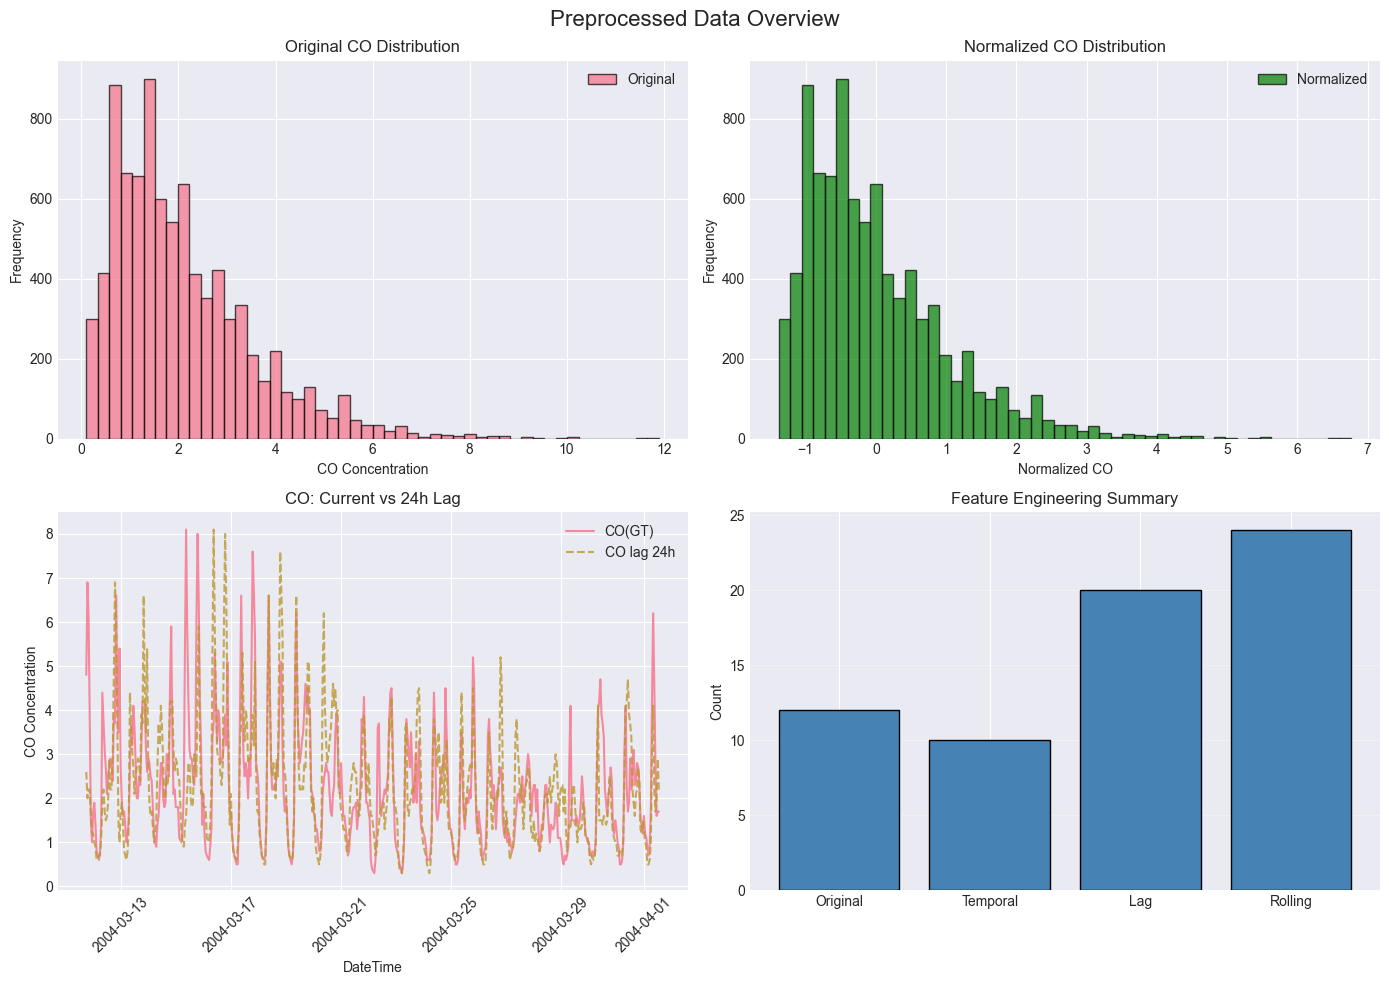

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
output_dir = 'preprocessing_output'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("DATA PREPROCESSING PIPELINE")
print("="*70)

# ============================================
# 1. LOAD DATA
# ============================================
print("\n[STEP 1] Loading data...")
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("✓ Loaded from AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("✓ Loaded from AirQualityUCI.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Merge temporal fields
if df['Date'].dtype == 'object':
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                     format='%d/%m/%Y %H.%M.%S', errors='coerce')
else:
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

print(f"  Original shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

# ============================================
# 2. REPLACE SENTINEL VALUES
# ============================================
print("\n[STEP 2] Replacing sentinel value -200 with NaN...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    count = (df[col] == -200.0).sum()
    df[col] = df[col].replace(-200.0, np.nan)
    if count > 0:
        print(f"  {col}: {count} values replaced")

# ============================================
# 3. DROP NMHC(GT) - TOO MANY MISSING
# ============================================
print("\n[STEP 3] Dropping NMHC(GT) (90.23% missing)...")
if 'NMHC(GT)' in df.columns:
    df = df.drop('NMHC(GT)', axis=1)
    print("✓ NMHC(GT) removed")

# ============================================
# 4. HANDLE MISSING VALUES
# ============================================
print("\n[STEP 4] Handling missing values...")

pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']
all_features = pollutants + sensors + meteo

before_missing = df[all_features].isnull().sum().sum()

# Strategy: Linear interpolation (≤6h) -> Forward fill (7-48h) -> Drop (>48h)
for col in all_features:
    # Linear interpolation for short gaps (limit 6 hours)
    df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')

    # Forward fill for medium gaps (up to 48 hours)
    df[col] = df[col].fillna(method='ffill', limit=48)

after_interpolation = df[all_features].isnull().sum().sum()
print(f"  Missing before: {before_missing}")
print(f"  Missing after interpolation: {after_interpolation}")
print(f"  Recovered: {before_missing - after_interpolation} values")

# Drop rows with remaining long gaps (>48h)
rows_before = len(df)
df = df.dropna(subset=all_features)
rows_after = len(df)
print(f"  Rows dropped (long gaps): {rows_before - rows_after}")
print(f"✓ Final shape: {df.shape}")

# ============================================
# 5. EXTRACT TEMPORAL FEATURES
# ============================================
print("\n[STEP 5] Creating temporal features...")
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['DayOfYear'] = df.index.dayofyear

# Cyclical encoding for hour (24h cycle)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for month (12 month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(f"✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.")

# ============================================
# 6. CREATE LAG FEATURES
# ============================================
print("\n[STEP 6] Creating lag features...")
lag_hours = [1, 3, 6, 12, 24]

for pollutant in pollutants:
    for lag in lag_hours:
        df[f'{pollutant.split("(")[0]}_lag{lag}h'] = df[pollutant].shift(lag)

print(f"✓ Created {len(pollutants) * len(lag_hours)} lag features")

# ============================================
# 7. CREATE ROLLING STATISTICS
# ============================================
print("\n[STEP 7] Creating rolling window features...")
windows = [6, 12, 24]

for pollutant in pollutants:
    for window in windows:
        # Rolling mean
        df[f'{pollutant.split("(")[0]}_rolling_mean_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).mean()

        # Rolling std
        df[f'{pollutant.split("(")[0]}_rolling_std_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).std()

print(f"✓ Created {len(pollutants) * len(windows) * 2} rolling features")

# ============================================
# 8. DROP ROWS WITH NAN FROM LAG FEATURES
# ============================================
print("\n[STEP 8] Handling NaN from lag/rolling features...")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"  Rows dropped: {rows_before - rows_after}")
print(f"✓ Clean shape: {df.shape}")

# ============================================
# 9. NORMALIZE FEATURES
# ============================================
print("\n[STEP 9] Normalizing continuous features...")

# Features to normalize (exclude temporal indicators)
features_to_normalize = (pollutants + sensors + meteo +
                         [col for col in df.columns if 'lag' in col or 'rolling' in col])

scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

print(f"✓ Normalized {len(features_to_normalize)} features")

# ============================================
# 10. TEMPORAL SPLIT (2004 train, 2005 test)
# ============================================
print("\n[STEP 10] Creating temporal train/test split...")

train_df = df_normalized[df_normalized['Year'] == 2004]
test_df = df_normalized[df_normalized['Year'] == 2005]

print(f"  Train set (2004): {train_df.shape}")
print(f"  Test set (2005): {test_df.shape}")

# ============================================
# 11. SAVE PREPROCESSED DATA
# ============================================
print("\n[STEP 11] Saving preprocessed data...")

# Save full preprocessed data (unnormalized)
df.to_csv(os.path.join(output_dir, 'preprocessed_data_full.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_full.csv")

# Save normalized data
df_normalized.to_csv(os.path.join(output_dir, 'preprocessed_data_normalized.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_normalized.csv")

# Save train/test splits
train_df.to_csv(os.path.join(output_dir, 'train_2004.csv'))
test_df.to_csv(os.path.join(output_dir, 'test_2005.csv'))
print(f"✓ Saved: {output_dir}/train_2004.csv")
print(f"✓ Saved: {output_dir}/test_2005.csv")

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
print(f"✓ Saved: {output_dir}/scaler.pkl")

# ============================================
# 12. SUMMARY STATISTICS
# ============================================
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\nFinal dataset:")
print(f"  Total samples: {len(df)}")
print(f"  Total features: {len(df.columns)}")
print(f"  Original features: {len(pollutants + sensors + meteo)}")
print(f"  Temporal features: {len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])])}")
print(f"  Lag features: {len([c for c in df.columns if 'lag' in c])}")
print(f"  Rolling features: {len([c for c in df.columns if 'rolling' in c])}")

print(f"\nTrain/Test split:")
print(f"  Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTarget variables (pollutants):")
for pol in pollutants:
    print(f"  {pol}: min={df[pol].min():.2f}, max={df[pol].max():.2f}, mean={df[pol].mean():.2f}")

# ============================================
# 13. VISUALIZATION
# ============================================
print("\n[STEP 12] Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Preprocessed Data Overview', fontsize=16)

# Original vs normalized CO
axes[0, 0].hist(df['CO(GT)'], bins=50, alpha=0.7, label='Original', edgecolor='black')
axes[0, 0].set_xlabel('CO Concentration')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original CO Distribution')
axes[0, 0].legend()

axes[0, 1].hist(df_normalized['CO(GT)'], bins=50, alpha=0.7,
                label='Normalized', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Normalized CO')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Normalized CO Distribution')
axes[0, 1].legend()

# Time series with lag feature
sample_size = 500
sample_df = df.iloc[:sample_size]
axes[1, 0].plot(sample_df.index, sample_df['CO(GT)'],
                label='CO(GT)', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(sample_df.index, sample_df['CO_lag24h'],
                label='CO lag 24h', linewidth=1.5, alpha=0.8, linestyle='--')
axes[1, 0].set_xlabel('DateTime')
axes[1, 0].set_ylabel('CO Concentration')
axes[1, 0].set_title('CO: Current vs 24h Lag')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature count by type
feature_types = {
    'Original': len(pollutants + sensors + meteo),
    'Temporal': len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])]),
    'Lag': len([c for c in df.columns if 'lag' in c]),
    'Rolling': len([c for c in df.columns if 'rolling' in c])
}
axes[1, 1].bar(feature_types.keys(), feature_types.values(), color='steelblue', edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Feature Engineering Summary')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'preprocessing_summary.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/preprocessing_summary.png")

print("\n" + "="*70)
print("PREPROCESSING COMPLETE")
print("="*70)
print(f"\nAll outputs saved to '{output_dir}/' directory")
print("\nNext steps:")
print("  1. Load train_2004.csv for model training")
print("  2. Load test_2005.csv for evaluation")
print("  3. Use scaler.pkl for new data normalization")

# Feature Engineering

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Configuration
output_dir = 'temporal_feature_engineering'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("MULTI-GRANULARITY FEATURE ENGINEERING & TEMPORAL SPLITTING")
print("="*70)

# ============================================
# 1. LOAD PREPROCESSED DATA
# ============================================
print("\n[STEP 1] Loading preprocessed data...")

# Load the preprocessed data
df = pd.read_csv('preprocessing_output/preprocessed_data_full.csv', index_col='DateTime', parse_dates=True)

print(f"✓ Loaded preprocessed data shape: {df.shape}")
print(f"✓ Date range: {df.index.min()} to {df.index.max()}")

# Define feature groups
pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print(f"✓ Features: {len(pollutants)} pollutants, {len(sensors)} sensors, {len(meteo)} meteo")

# ============================================
# 2. CREATE HOURLY FEATURES (FINE-GRAINED)
# ============================================
print("\n[STEP 2] Creating hourly features...")

# Basic temporal features
df_hourly = df.copy()
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = (df_hourly['day_of_week'] >= 5).astype(int)

# Cyclical encoding
def encode_cyclical(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df_hourly = encode_cyclical(df_hourly, 'hour', 24)
df_hourly = encode_cyclical(df_hourly, 'day_of_week', 7)

# Short-term lagged features (1-12 hours)
print("  Creating short-term lagged features...")
for pollutant in pollutants:
    for lag in [1, 3, 6, 12]:  # 1h, 3h, 6h, 12h
        df_hourly[f'{pollutant}_lag_{lag}h'] = df_hourly[pollutant].shift(lag)

# Short-term moving averages (4-12 hours)
print("  Creating short-term moving averages...")
for pollutant in pollutants:
    for window in [4, 8, 12]:  # 4h, 8h, 12h
        df_hourly[f'{pollutant}_ma_{window}h'] = df_hourly[pollutant].rolling(window=window, min_periods=1).mean()

# Rate of change features
print("  Creating rate of change features...")
for pollutant in pollutants:
    df_hourly[f'{pollutant}_hourly_change'] = df_hourly[pollutant].diff()
    df_hourly[f'{pollutant}_hourly_pct_change'] = df_hourly[pollutant].pct_change()

# Remove rows with NaN from lag features
df_hourly_clean = df_hourly.dropna()
print(f"✓ Hourly features shape: {df_hourly_clean.shape}")

# ============================================
# 3. CREATE DAILY FEATURES (COARSE-GRAINED)
# ============================================
print("\n[STEP 3] Creating daily features...")

# Create daily aggregates
daily_agg_dict = {}
for pollutant in pollutants:
    daily_agg_dict[pollutant] = ['mean', 'max', 'std']
for sensor in sensors:
    daily_agg_dict[sensor] = ['mean', 'max']
for meteo_var in meteo:
    daily_agg_dict[meteo_var] = ['mean', 'max']

df_daily = df.resample('D').agg(daily_agg_dict)
df_daily.columns = ['_'.join(col).strip() for col in df_daily.columns.values]

# Add daily temporal features
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['is_weekend'] = (df_daily['day_of_week'] >= 5).astype(int)

# Daily lag features
print("  Creating daily lagged features...")
for col in ['CO(GT)_mean', 'C6H6(GT)_mean', 'NOx(GT)_mean', 'NO2(GT)_mean']:
    for lag in [1, 2, 7]:  # 1 day, 2 days, 1 week
        df_daily[f'{col}_lag_{lag}d'] = df_daily[col].shift(lag)

df_daily_clean = df_daily.dropna()
print(f"✓ Daily features shape: {df_daily_clean.shape}")

# ============================================
# 4. CREATE FULL FEATURES (HOURLY + DAILY MERGED)
# ============================================
print("\n[STEP 4] Creating full features (hourly + daily merged)...")

# Prepare daily data for merging (ensure proper datetime index)
daily_for_merge = df_daily_clean.copy()
daily_for_merge.index = pd.to_datetime(daily_for_merge.index)

# Add date column to hourly data for merging
df_full = df_hourly_clean.copy()
df_full['merge_date'] = df_full.index.normalize()

# Select daily features to merge (avoid duplicate temporal features)
daily_features_to_merge = [col for col in daily_for_merge.columns 
                          if not col in ['day_of_week', 'month', 'is_weekend']]

# Merge daily features into hourly data
df_full = df_full.merge(
    daily_for_merge[daily_features_to_merge], 
    left_on='merge_date', 
    right_index=True, 
    how='left',
    suffixes=('', '_daily')
)

# Remove temporary column
df_full = df_full.drop('merge_date', axis=1)
df_full_clean = df_full.dropna()

print(f"✓ Full features shape: {df_full_clean.shape}")
print(f"✓ Added {len(daily_features_to_merge)} daily features to hourly data")

# ============================================
# 5. TEMPORAL DATA SPLITTING (3 VERSIONS)
# ============================================
print("\n[STEP 5] Creating temporal splits for all three versions...")

def create_temporal_splits(df, target_cols, features_exclude):
    """创建时序分割的训练集、验证集、测试集"""
    # 定义特征和目标
    X = df.drop(features_exclude, axis=1)
    y = df[target_cols] if isinstance(target_cols, list) else df[[target_cols]]
    
    # 按年份分割 (2004训练, 2005测试)
    train_mask = df.index.year == 2004
    test_mask = df.index.year == 2005
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    # 从训练集创建验证集 (后20%)
    split_point = int(0.8 * len(X_train))
    X_train_final = X_train.iloc[:split_point]
    X_val = X_train.iloc[split_point:]
    y_train_final = y_train.iloc[:split_point]
    y_val = y_train.iloc[split_point:]
    
    return X_train_final, X_val, X_test, y_train_final, y_val, y_test

# HOURLY VERSION
print("  Creating hourly version splits...")
features_exclude_hourly = pollutants + [col for col in df_hourly_clean.columns if 'time_of_day' in col]
X_train_h, X_val_h, X_test_h, y_train_h, y_val_h, y_test_h = create_temporal_splits(
    df_hourly_clean, pollutants, features_exclude_hourly
)

# DAILY VERSION  
print("  Creating daily version splits...")
# For daily, use CO mean as target example
target_daily = 'CO(GT)_mean'
features_exclude_daily = [col for col in df_daily_clean.columns 
                         if any(pollutant in col for pollutant in pollutants)]
X_train_d, X_val_d, X_test_d, y_train_d, y_val_d, y_test_d = create_temporal_splits(
    df_daily_clean, target_daily, features_exclude_daily
)

# FULL VERSION
print("  Creating full version splits...")
features_exclude_full = pollutants + [col for col in df_full_clean.columns if 'time_of_day' in col]
X_train_f, X_val_f, X_test_f, y_train_f, y_val_f, y_test_f = create_temporal_splits(
    df_full_clean, pollutants, features_exclude_full
)

print("✓ Temporal splits completed:")
print(f"  Hourly - Train: {X_train_h.shape}, Val: {X_val_h.shape}, Test: {X_test_h.shape}")
print(f"  Daily  - Train: {X_train_d.shape}, Val: {X_val_d.shape}, Test: {X_test_d.shape}")
print(f"  Full   - Train: {X_train_f.shape}, Val: {X_val_f.shape}, Test: {X_test_f.shape}")

# ============================================
# 6. FEATURE ANALYSIS & SUMMARY
# ============================================
print("\n[STEP 6] Analyzing feature sets...")

# Feature counts by category
hourly_feature_count = X_train_h.shape[1]
daily_feature_count = X_train_d.shape[1]
full_feature_count = X_train_f.shape[1]

print("\n📊 FEATURE SETS SUMMARY:")
print("="*50)
print(f"🏠 HOURLY FEATURES (Fine-grained):")
print(f"   • Total features: {hourly_feature_count}")
print(f"   • Training samples: {X_train_h.shape[0]}")
print(f"   • Validation samples: {X_val_h.shape[0]}")
print(f"   • Test samples: {X_test_h.shape[0]}")
print(f"   • Includes: Short-term lags, hourly patterns")

print(f"\n📅 DAILY FEATURES (Coarse-grained):")
print(f"   • Total features: {daily_feature_count}")
print(f"   • Training samples: {X_train_d.shape[0]}")
print(f"   • Validation samples: {X_val_d.shape[0]}")
print(f"   • Test samples: {X_test_d.shape[0]}")
print(f"   • Includes: Daily aggregates, seasonal patterns")

print(f"\n🔥 FULL FEATURES (Hourly + Daily):")
print(f"   • Total features: {full_feature_count}")
print(f"   • Training samples: {X_train_f.shape[0]}")
print(f"   • Validation samples: {X_val_f.shape[0]}")
print(f"   • Test samples: {X_test_f.shape[0]}")
print(f"   • Includes: Both fine and coarse temporal patterns")

# ============================================
# 7. SAVE ALL DATASETS
# ============================================
print("\n[STEP 7] Saving all datasets...")

# Save full feature datasets
df_hourly_clean.to_csv(os.path.join(output_dir, 'features_hourly_full.csv'))
df_daily_clean.to_csv(os.path.join(output_dir, 'features_daily_full.csv'))
df_full_clean.to_csv(os.path.join(output_dir, 'features_full_merged.csv'))
print("✓ Saved full feature datasets")

# Save hourly version
pd.concat([X_train_h, y_train_h], axis=1).to_csv(os.path.join(output_dir, 'train_hourly.csv'))
pd.concat([X_val_h, y_val_h], axis=1).to_csv(os.path.join(output_dir, 'val_hourly.csv'))
pd.concat([X_test_h, y_test_h], axis=1).to_csv(os.path.join(output_dir, 'test_hourly.csv'))
print("✓ Saved hourly version splits")

# Save daily version
pd.concat([X_train_d, y_train_d], axis=1).to_csv(os.path.join(output_dir, 'train_daily.csv'))
pd.concat([X_val_d, y_val_d], axis=1).to_csv(os.path.join(output_dir, 'val_daily.csv'))
pd.concat([X_test_d, y_test_d], axis=1).to_csv(os.path.join(output_dir, 'test_daily.csv'))
print("✓ Saved daily version splits")

# Save full version
pd.concat([X_train_f, y_train_f], axis=1).to_csv(os.path.join(output_dir, 'train_full.csv'))
pd.concat([X_val_f, y_val_f], axis=1).to_csv(os.path.join(output_dir, 'val_full.csv'))
pd.concat([X_test_f, y_test_f], axis=1).to_csv(os.path.join(output_dir, 'test_full.csv'))
print("✓ Saved full version splits")

# Save separate X and y files for modeling
datasets = {
    'hourly': (X_train_h, X_val_h, X_test_h, y_train_h, y_val_h, y_test_h),
    'daily': (X_train_d, X_val_d, X_test_d, y_train_d, y_val_d, y_test_d),
    'full': (X_train_f, X_val_f, X_test_f, y_train_f, y_val_f, y_test_f)
}

for version, (X_train, X_val, X_test, y_train, y_val, y_test) in datasets.items():
    X_train.to_csv(os.path.join(output_dir, f'X_train_{version}.csv'))
    X_val.to_csv(os.path.join(output_dir, f'X_val_{version}.csv'))
    X_test.to_csv(os.path.join(output_dir, f'X_test_{version}.csv'))
    y_train.to_csv(os.path.join(output_dir, f'y_train_{version}.csv'))
    y_val.to_csv(os.path.join(output_dir, f'y_val_{version}.csv'))
    y_test.to_csv(os.path.join(output_dir, f'y_test_{version}.csv'))

print("✓ Saved separate X/y files for modeling")

# Save dataset summary
summary = pd.DataFrame({
    'version': ['hourly', 'daily', 'full'],
    'features': [hourly_feature_count, daily_feature_count, full_feature_count],
    'train_samples': [X_train_h.shape[0], X_train_d.shape[0], X_train_f.shape[0]],
    'val_samples': [X_val_h.shape[0], X_val_d.shape[0], X_val_f.shape[0]],
    'test_samples': [X_test_h.shape[0], X_test_d.shape[0], X_test_f.shape[0]],
    'train_period': [
        f"{X_train_h.index.min().date()} to {X_train_h.index.max().date()}",
        f"{X_train_d.index.min().date()} to {X_train_d.index.max().date()}",
        f"{X_train_f.index.min().date()} to {X_train_f.index.max().date()}"
    ],
    'test_period': [
        f"{X_test_h.index.min().date()} to {X_test_h.index.max().date()}",
        f"{X_test_d.index.min().date()} to {X_test_d.index.max().date()}",
        f"{X_test_f.index.min().date()} to {X_test_f.index.max().date()}"
    ]
})
summary.to_csv(os.path.join(output_dir, 'dataset_summary.csv'), index=False)
print("✓ Saved dataset summary")

print("\n" + "="*70)
print("MULTI-GRANULARITY FEATURE ENGINEERING COMPLETE!")
print("="*70)

print(f"\n🎯 THREE DATASET VERSIONS CREATED:")
print(f"   1. HOURLY - {hourly_feature_count} features (fine-grained)")
print(f"   2. DAILY  - {daily_feature_count} features (coarse-grained)") 
print(f"   3. FULL   - {full_feature_count} features (combined)")
print(f"\n💾 All files saved to: {output_dir}/")
print(f"\n📁 Files created:")
print(f"   • train/val/test_hourly.csv")
print(f"   • train/val/test_daily.csv") 
print(f"   • train/val/test_full.csv")
print(f"   • X/y_train/val/test_{version}.csv")
print(f"   • features_*_full.csv")
print(f"   • dataset_summary.csv")

MULTI-GRANULARITY FEATURE ENGINEERING & TEMPORAL SPLITTING

[STEP 1] Loading preprocessed data...
✓ Loaded preprocessed data shape: (8809, 66)
✓ Date range: 2004-03-11 18:00:00 to 2005-04-04 14:00:00
✓ Features: 4 pollutants, 5 sensors, 3 meteo

[STEP 2] Creating hourly features...
  Creating short-term lagged features...
  Creating short-term moving averages...
  Creating rate of change features...
✓ Hourly features shape: (8797, 110)

[STEP 3] Creating daily features...
  Creating daily lagged features...
✓ Daily features shape: (349, 43)

[STEP 4] Creating full features (hourly + daily merged)...
✓ Full features shape: (8213, 150)
✓ Added 40 daily features to hourly data

[STEP 5] Creating temporal splits for all three versions...
  Creating hourly version splits...
  Creating daily version splits...
  Creating full version splits...
✓ Temporal splits completed:
  Hourly - Train: (5252, 106), Val: (1314, 106), Test: (2231, 106)
  Daily  - Train: (204, 19), Val: (51, 19), Test: (94, 

In [12]:
X_train_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-03-17 00:00:00,1205.0,925.0,922.0,1547.0,1314.0,15.5,52.9,0.9271,0,2,...,1.966667,13.5,16.091667,8.45,176.166667,209.791667,132.0,115.75,117.104167,108.833333
2004-03-17 01:00:00,1072.0,784.0,1066.0,1442.0,1114.0,15.5,51.9,0.9059,1,2,...,1.966667,13.5,16.091667,8.45,176.166667,209.791667,132.0,115.75,117.104167,108.833333
2004-03-17 02:00:00,998.0,714.0,1169.0,1383.0,992.0,14.1,55.6,0.8910,2,2,...,1.966667,13.5,16.091667,8.45,176.166667,209.791667,132.0,115.75,117.104167,108.833333
2004-03-17 03:00:00,933.0,625.0,1292.0,1332.0,884.0,13.1,57.9,0.8666,3,2,...,1.966667,13.5,16.091667,8.45,176.166667,209.791667,132.0,115.75,117.104167,108.833333
2004-03-17 04:00:00,883.0,577.0,1396.0,1303.0,808.0,12.7,57.9,0.8447,4,2,...,1.966667,13.5,16.091667,8.45,176.166667,209.791667,132.0,115.75,117.104167,108.833333


In [13]:
X_val_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-11-09 19:00:00,1275.0,1294.0,570.0,1605.0,1280.0,8.6,75.5,0.8469,19,1,...,4.177083,8.441667,5.195833,22.55,322.698529,150.645833,484.104167,106.814951,67.645833,99.770833
2004-11-09 20:00:00,1237.0,1194.0,615.0,1508.0,1193.0,8.8,76.6,0.8678,20,1,...,4.177083,8.441667,5.195833,22.55,322.698529,150.645833,484.104167,106.814951,67.645833,99.770833
2004-11-09 21:00:00,1101.0,963.0,748.0,1320.0,966.0,8.0,81.0,0.8714,21,1,...,4.177083,8.441667,5.195833,22.55,322.698529,150.645833,484.104167,106.814951,67.645833,99.770833
2004-11-09 22:00:00,962.0,778.0,911.0,1162.0,752.0,7.3,85.7,0.8818,22,1,...,4.177083,8.441667,5.195833,22.55,322.698529,150.645833,484.104167,106.814951,67.645833,99.770833
2004-11-09 23:00:00,841.0,680.0,1052.0,1067.0,594.0,6.5,85.6,0.8353,23,1,...,4.177083,8.441667,5.195833,22.55,322.698529,150.645833,484.104167,106.814951,67.645833,99.770833


In [14]:
X_test_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,day_of_week,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,1046.0,724.0,848.0,898.0,1201.0,8.2,40.1,0.4375,0,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 01:00:00,1275.0,930.0,649.0,1024.0,1617.0,5.3,50.7,0.4564,1,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 02:00:00,1173.0,878.0,738.0,1002.0,1355.0,5.9,50.0,0.4689,2,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 03:00:00,1163.0,881.0,748.0,1001.0,1296.0,4.9,53.9,0.4693,3,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 04:00:00,1054.0,791.0,830.0,967.0,1131.0,4.3,55.3,0.4650,4,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375


# Anomaly and Event Detection:

ANOMALY AND EVENT DETECTION ANALYSIS

[STEP 1] Loading preprocessed data...
✓ Data shape: (8809, 66)
✓ Target: CO(GT)
✓ Features: ['PT08.S1(CO)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month']

[STEP 2] Residual-based anomaly detection...
  Training samples: 6578
  Test samples: 2231
  Training Random Forest model...
  Residual std: 0.2261
  Anomaly threshold: ±0.6784
  Training anomalies: 144 (2.19%)
  Test anomalies: 555 (24.88%)

[STEP 3] Unsupervised anomaly detection...
  Training Isolation Forest...
  Training Local Outlier Factor...
  Isolation Forest anomalies: 441 (5.01%)
  LOF anomalies: 441 (5.01%)

[STEP 4] Analyzing anomalies with meteorological features...

ISOLATION FOREST ANOMALY ANALYSIS:
----------------------------------------
  Temperature - Anomalies: 21.23°C, Normal: 17.95°C
  Weekend ratio - Anomalies: 0.154, Normal: 0.301
  Seasonal distribution:
    Winter: Anomalies 0.245, Normal 0.237
    Spring: Anomalies 0.213, Normal 0.311
    Summer: Anomalies 0.293, Norm

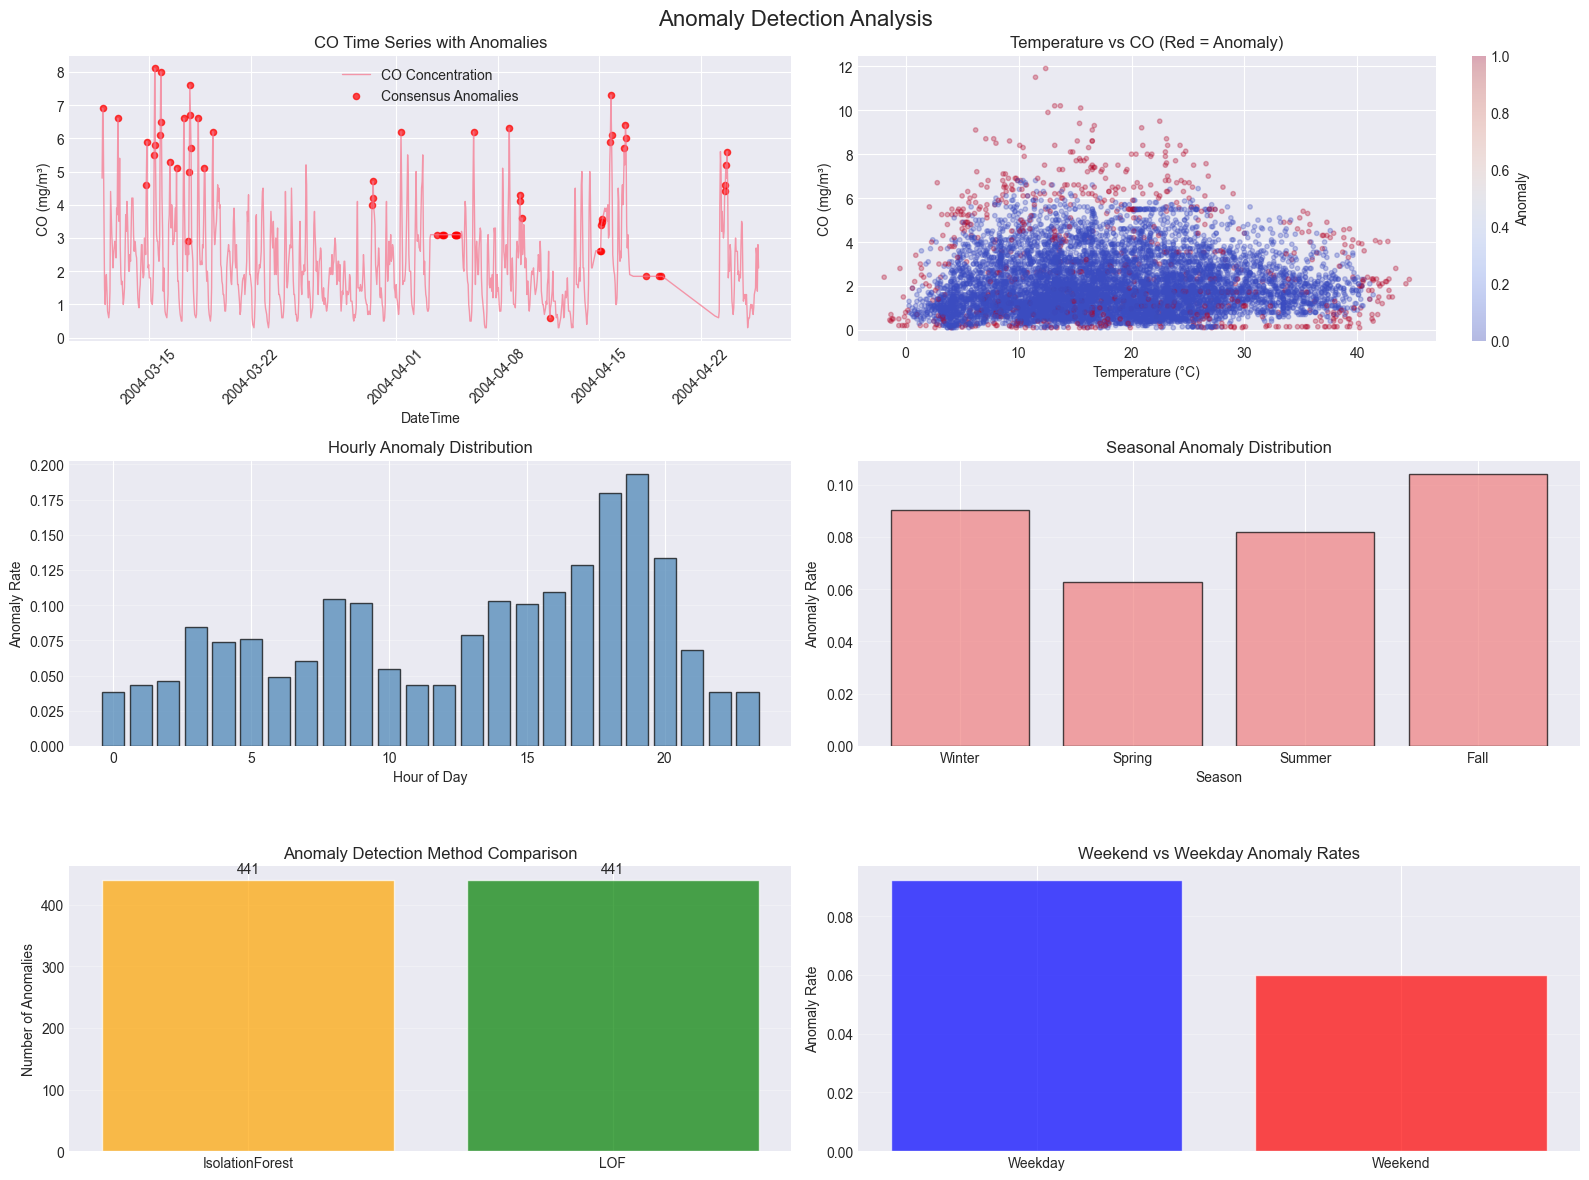

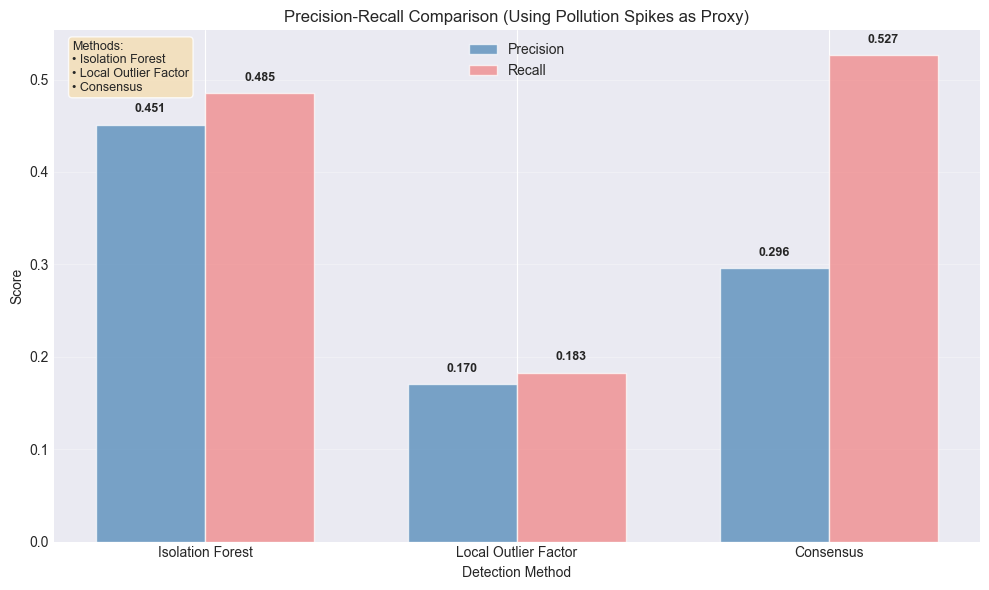

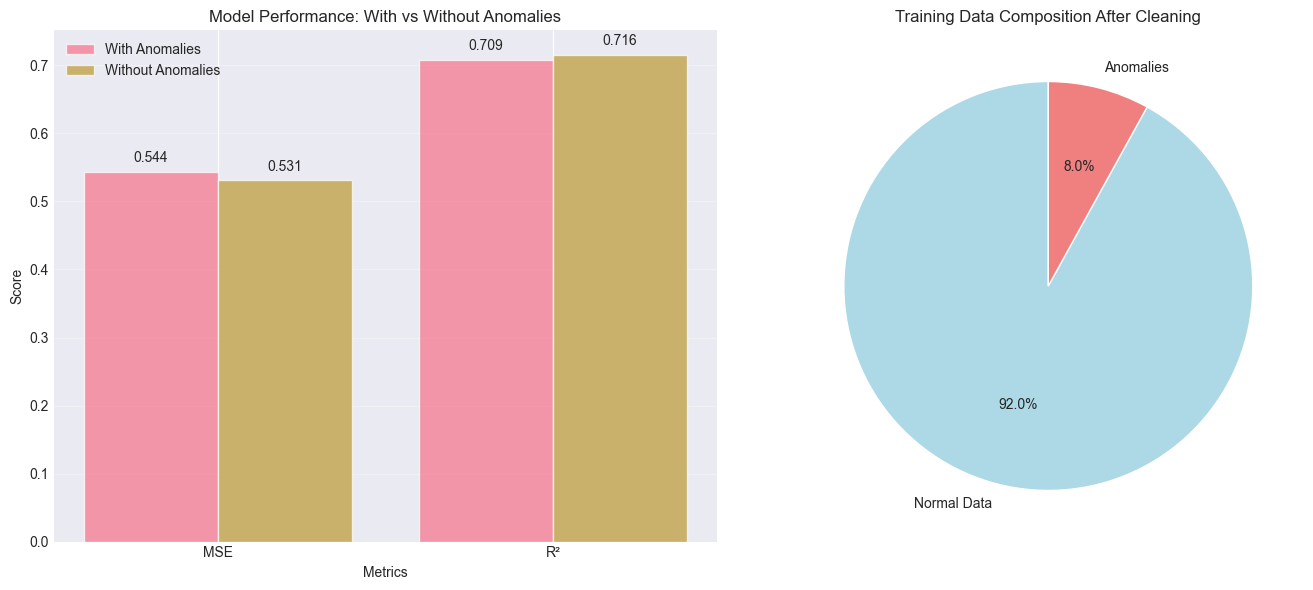

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 配置参数
output_dir = 'anomaly_detection'
os.makedirs(output_dir, exist_ok=True)

print("=" * 70)
print("ANOMALY AND EVENT DETECTION ANALYSIS")
print("=" * 70)

# ============================================
# 1. 加载预处理后的数据
# ============================================
print("\n[STEP 1] Loading preprocessed data...")

# 加载完整的预处理数据
df = pd.read_csv('preprocessing_output/preprocessed_data_full.csv',
                 index_col='DateTime', parse_dates=True)

# 选择CO作为异常检测的主要目标污染物
target_pollutant = 'CO(GT)'
features = ['PT08.S1(CO)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month']

print(f"✓ Data shape: {df.shape}")
print(f"✓ Target: {target_pollutant}")
print(f"✓ Features: {features}")

# ============================================
# 2. 基于残差的异常检测方法
# ============================================
print("\n[STEP 2] Residual-based anomaly detection...")

# 准备回归分析数据
data_clean = df[features + [target_pollutant]].dropna()
X = data_clean[features]
y = data_clean[target_pollutant]

# 按时间分割数据（使用2004年数据训练）
train_mask = data_clean.index.year == 2004
test_mask = data_clean.index.year == 2005

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

# 训练随机森林回归模型
print("  Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 预测并计算残差（真实值 - 预测值）
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# 设置异常阈值（3倍标准差）
residual_std = residuals_train.std()
threshold = 3 * residual_std

# 标记异常点（残差绝对值超过阈值）
residual_anomalies_train = np.abs(residuals_train) > threshold
residual_anomalies_test = np.abs(residuals_test) > threshold

print(f"  Residual std: {residual_std:.4f}")
print(f"  Anomaly threshold: ±{threshold:.4f}")
print(f"  Training anomalies: {residual_anomalies_train.sum()} ({residual_anomalies_train.mean()*100:.2f}%)")
print(f"  Test anomalies: {residual_anomalies_test.sum()} ({residual_anomalies_test.mean()*100:.2f}%)")

# ============================================
# 3. 无监督异常检测方法
# ============================================
print("\n[STEP 3] Unsupervised anomaly detection...")

# 准备无监督学习特征
unsupervised_features = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH', 'AH']
X_unsupervised = df[unsupervised_features].dropna()

# 特征标准化（无监督方法对尺度敏感）
scaler_unsupervised = StandardScaler()
X_scaled = scaler_unsupervised.fit_transform(X_unsupervised)

# 方法1：Isolation Forest
print("  Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_anomalies = iso_forest.fit_predict(X_scaled)
iso_anomalies = iso_anomalies == -1  # 转换为布尔值（-1表示异常，True=异常）

# 方法2：Local Outlier Factor
print("  Training Local Outlier Factor...")
lof = LocalOutlierFactor(contamination=0.05, n_neighbors=50)
lof_anomalies = lof.fit_predict(X_scaled)
lof_anomalies = lof_anomalies == -1

print(f"  Isolation Forest anomalies: {iso_anomalies.sum()} ({iso_anomalies.mean()*100:.2f}%)")
print(f"  LOF anomalies: {lof_anomalies.sum()} ({lof_anomalies.mean()*100:.2f}%)")

# 创建异常检测结果数据框
anomaly_df = X_unsupervised.copy()
anomaly_df['Residual_Anomaly'] = False
anomaly_df['IsolationForest_Anomaly'] = iso_anomalies
anomaly_df['LOF_Anomaly'] = lof_anomalies

# 添加时间特征用于后续分析
anomaly_df['Hour'] = anomaly_df.index.hour
anomaly_df['DayOfWeek'] = anomaly_df.index.dayofweek
anomaly_df['Month'] = anomaly_df.index.month
anomaly_df['IsWeekend'] = anomaly_df['DayOfWeek'].isin([5, 6])
anomaly_df['Season'] = (anomaly_df['Month'] % 12 + 3) // 3  # 1:Winter, 2:Spring, etc.

# ============================================
# 4. 异常与气象特征关联分析
# ============================================
print("\n[STEP 4] Analyzing anomalies with meteorological features...")

def analyze_anomaly_patterns(anomaly_series, name):
    """分析异常点与气象、时间特征的关联模式"""
    anomalies = anomaly_df[anomaly_series]
    normal = ~anomalies

    print(f"\n{name} ANOMALY ANALYSIS:")
    print("-" * 40)

    # 温度分析：比较异常点和正常点的平均温度
    temp_anomalies = anomaly_df.loc[anomalies, 'T']
    temp_normal = anomaly_df.loc[normal, 'T']
    print(f"  Temperature - Anomalies: {temp_anomalies.mean():.2f}°C, Normal: {temp_normal.mean():.2f}°C")

    # 周末分析：比较异常点在周末的比例
    weekend_anomalies = anomaly_df.loc[anomalies, 'IsWeekend'].mean()
    weekend_normal = anomaly_df.loc[normal, 'IsWeekend'].mean()
    print(f"  Weekend ratio - Anomalies: {weekend_anomalies:.3f}, Normal: {weekend_normal:.3f}")

    # 季节分析：分析异常点的季节分布
    seasonal_anomalies = anomaly_df.loc[anomalies, 'Season'].value_counts(normalize=True).sort_index()
    seasonal_normal = anomaly_df.loc[normal, 'Season'].value_counts(normalize=True).sort_index()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    print("  Seasonal distribution:")
    for i, season in enumerate(seasons):
        anomaly_rate = seasonal_anomalies.get(i+1, 0)
        normal_rate = seasonal_normal.get(i+1, 0)
        print(f"    {season}: Anomalies {anomaly_rate:.3f}, Normal {normal_rate:.3f}")

    # 小时模式：分析异常点在一天中的分布
    hourly_anomalies = anomaly_df.loc[anomalies, 'Hour'].value_counts(normalize=True).sort_index()
    print("  Top 5 anomaly hours:")
    for hour, freq in hourly_anomalies.head().items():
        print(f"    Hour {hour:2d}: {freq:.3f}")

# 分别分析两种无监督方法的异常模式
analyze_anomaly_patterns('IsolationForest_Anomaly', 'ISOLATION FOREST')
analyze_anomaly_patterns('LOF_Anomaly', 'LOCAL OUTLIER FACTOR')

# ============================================
# 5. 共识异常与污染事件检测
# ============================================
print("\n[STEP 5] Consensus anomaly detection...")

# 定义共识异常（至少被一种方法检测到）
anomaly_df['Consensus_Anomaly'] = (
    anomaly_df['IsolationForest_Anomaly'].astype(int) +
    anomaly_df['LOF_Anomaly'].astype(int)
) >= 1

consensus_anomalies = anomaly_df['Consensus_Anomaly']
print(f"\n CONSENSUS ANOMALIES:")
print(f"  Total consensus anomalies: {consensus_anomalies.sum()} ({consensus_anomalies.mean()*100:.2f}%)")

# 分析共识异常的模式
analyze_anomaly_patterns('Consensus_Anomaly', 'CONSENSUS')

# 检测污染峰值（极端高值）
co_threshold_high = anomaly_df['CO(GT)'].quantile(0.95)
pollution_spikes = anomaly_df['CO(GT)'] > co_threshold_high
anomaly_df['Pollution_Spike'] = pollution_spikes

print(f"\n🌫 POLLUTION SPIKES (top 5%):")
print(f"  CO threshold: {co_threshold_high:.3f} mg/m³")
print(f"  Pollution spikes: {pollution_spikes.sum()} ({pollution_spikes.mean()*100:.2f}%)")

# 分析异常与污染峰值的重叠情况
anomaly_spike_overlap = (consensus_anomalies & pollution_spikes).sum()
print(f"  Anomalies that are pollution spikes: {anomaly_spike_overlap}")

# ============================================
# 6. 结果可视化
# ============================================
print("\n[STEP 6] Creating visualizations...")

# 创建主分析图表
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Anomaly Detection Analysis', fontsize=16, y=0.98)

# 子图1: 时间序列异常标记
sample_data = anomaly_df.iloc[:1000]
axes[0, 0].plot(sample_data.index, sample_data['CO(GT)'],
                label='CO Concentration', linewidth=1, alpha=0.7)
anomaly_points = sample_data[sample_data['Consensus_Anomaly']]
axes[0, 0].scatter(anomaly_points.index, anomaly_points['CO(GT)'],
                  color='red', s=20, label='Consensus Anomalies', alpha=0.7)
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('CO (mg/m³)')
axes[0, 0].set_title('CO Time Series with Anomalies')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 子图2: 温度-CO散点图（异常着色）
scatter = axes[0, 1].scatter(anomaly_df['T'], anomaly_df['CO(GT)'],
                            c=anomaly_df['Consensus_Anomaly'].astype(int),
                            cmap='coolwarm', alpha=0.3, s=10)
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('CO (mg/m³)')
axes[0, 1].set_title('Temperature vs CO (Red = Anomaly)')
plt.colorbar(scatter, ax=axes[0, 1], label='Anomaly')

# 子图3: 小时异常率分布
hourly_anomaly_rate = anomaly_df.groupby('Hour')['Consensus_Anomaly'].mean()
axes[1, 0].bar(hourly_anomaly_rate.index, hourly_anomaly_rate.values,
               color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Anomaly Rate')
axes[1, 0].set_title('Hourly Anomaly Distribution')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4: 季节异常率分布
seasonal_anomaly_rate = anomaly_df.groupby('Season')['Consensus_Anomaly'].mean()
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
axes[1, 1].bar(seasons, seasonal_anomaly_rate.values,
               color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Anomaly Rate')
axes[1, 1].set_title('Seasonal Anomaly Distribution')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 子图5: 方法对比
methods = ['IsolationForest', 'LOF']
anomaly_counts = [anomaly_df['IsolationForest_Anomaly'].sum(),
                  anomaly_df['LOF_Anomaly'].sum()]
axes[2, 0].bar(methods, anomaly_counts, color=['orange', 'green'], alpha=0.7)
axes[2, 0].set_ylabel('Number of Anomalies')
axes[2, 0].set_title('Anomaly Detection Method Comparison')
axes[2, 0].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(anomaly_counts):
    axes[2, 0].text(i, count + 5, str(count), ha='center', va='bottom')

# 子图6: 工作日vs周末异常率
weekend_anomaly_rate = anomaly_df.groupby('IsWeekend')['Consensus_Anomaly'].mean()
axes[2, 1].bar(['Weekday', 'Weekend'], weekend_anomaly_rate.values,
               color=['blue', 'red'], alpha=0.7)
axes[2, 1].set_ylabel('Anomaly Rate')
axes[2, 1].set_title('Weekend vs Weekday Anomaly Rates')
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'anomaly_analysis_comprehensive.png'),
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/anomaly_analysis_comprehensive.png")

# 创建精确度-召回率比较图
fig, ax = plt.subplots(figsize=(10, 6))

# 计算各方法的精确度和召回率（使用污染峰值作为代理真实标签）
methods_data = {
    'Isolation Forest': (anomaly_df['IsolationForest_Anomaly'], 'orange'),
    'Local Outlier Factor': (anomaly_df['LOF_Anomaly'], 'green'),
    'Consensus': (anomaly_df['Consensus_Anomaly'], 'red')
}

results = []
for method_name, (anomalies, color) in methods_data.items():
    tp = (anomalies & pollution_spikes).sum()
    fp = (anomalies & ~pollution_spikes).sum()
    fn = (~anomalies & pollution_spikes).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    results.append({
        'Method': method_name,
        'Precision': precision,
        'Recall': recall,
        'Color': color
    })

results_df = pd.DataFrame(results)

# 绘制精确度和召回率柱状图
x_pos = np.arange(len(results_df))
width = 0.35

# 创建图形 - 使用统一的颜色方案
precision_color = 'steelblue'
recall_color = 'lightcoral'

# 绘制精确度柱子
precision_bars = ax.bar(x_pos - width/2, results_df['Precision'], width,
                       color=precision_color, alpha=0.7, label='Precision')

# 绘制召回率柱子
recall_bars = ax.bar(x_pos + width/2, results_df['Recall'], width,
                    color=recall_color, alpha=0.7, label='Recall')

ax.set_xlabel('Detection Method')
ax.set_ylabel('Score')
ax.set_title('Precision-Recall Comparison (Using Pollution Spikes as Proxy)')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Method'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 在柱状图上添加数值标签
for i, (prec, rec) in enumerate(zip(results_df['Precision'], results_df['Recall'])):
    ax.text(i - width/2, prec + 0.01, f'{prec:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(i + width/2, rec + 0.01, f'{rec:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 添加方法说明文本
ax.text(0.02, 0.98, 'Methods:\n• Isolation Forest\n• Local Outlier Factor\n• Consensus',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_comparison.png'),
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/precision_recall_comparison.png")
# ============================================
# 7. 精确度-召回率权衡分析
# ============================================
print("\n[STEP 7] Precision-Recall trade-off analysis...")

def evaluate_anomaly_method(method_anomalies, true_positives, method_name):
    """评估异常检测方法的性能"""
    tp = (method_anomalies & true_positives).sum()
    fp = (method_anomalies & ~true_positives).sum()
    fn = (~method_anomalies & true_positives).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{method_name}:")
    print(f"  Precision: {precision:.3f} ({tp}/{tp+fp})")
    print(f"  Recall:    {recall:.3f} ({tp}/{tp+fn})")
    print(f"  F1-score:  {f1:.3f}")

# 使用污染峰值作为真实异常的代理
true_positive_proxy = pollution_spikes

print("\n PRECISION-RECALL ANALYSIS (Using Pollution Spikes as Proxy):")
evaluate_anomaly_method(anomaly_df['IsolationForest_Anomaly'], true_positive_proxy, 'Isolation Forest')
evaluate_anomaly_method(anomaly_df['LOF_Anomaly'], true_positive_proxy, 'Local Outlier Factor')
evaluate_anomaly_method(anomaly_df['Consensus_Anomaly'], true_positive_proxy, 'Consensus')

# ============================================
# 8. 模型鲁棒性影响分析
# ============================================
print("\n[STEP 8] Analyzing impact on model robustness...")

# 准备鲁棒性分析数据
X_robust = df[features + [target_pollutant]].dropna()
y_robust = X_robust[target_pollutant]
X_robust = X_robust[features]

# 按时间分割数据
train_idx = X_robust.index.year == 2004
test_idx = X_robust.index.year == 2005

X_train_r = X_robust[train_idx]
y_train_r = y_robust[train_idx]
X_test_r = X_robust[test_idx]
y_test_r = y_robust[test_idx]

# 识别训练数据中的共识异常
train_anomalies = anomaly_df.loc[X_train_r.index, 'Consensus_Anomaly']

# 模型1：使用包含异常的数据训练
model_with_anomalies = RandomForestRegressor(n_estimators=100, random_state=42)
model_with_anomalies.fit(X_train_r, y_train_r)
y_pred_with = model_with_anomalies.predict(X_test_r)

# 模型2：使用清洗后的数据训练（移除异常）
X_train_clean = X_train_r[~train_anomalies]
y_train_clean = y_train_r[~train_anomalies]
model_without_anomalies = RandomForestRegressor(n_estimators=100, random_state=42)
model_without_anomalies.fit(X_train_clean, y_train_clean)
y_pred_without = model_without_anomalies.predict(X_test_r)

# 计算模型性能指标
mse_with = mean_squared_error(y_test_r, y_pred_with)
mse_without = mean_squared_error(y_test_r, y_pred_without)
r2_with = r2_score(y_test_r, y_pred_with)
r2_without = r2_score(y_test_r, y_pred_without)

print("\n🛡 MODEL ROBUSTNESS COMPARISON:")
print("=" * 50)
print(f"Model trained WITH anomalies:")
print(f"  MSE:  {mse_with:.4f}")
print(f"  R²:   {r2_with:.4f}")
print(f"  Training samples: {len(X_train_r)}")
print(f"\nModel trained WITHOUT anomalies:")
print(f"  MSE:  {mse_without:.4f}")
print(f"  R²:   {r2_without:.4f}")
print(f"  Training samples: {len(X_train_clean)}")
print(f"  Anomalies removed: {train_anomalies.sum()}")

improvement = ((mse_with - mse_without) / mse_with) * 100
print(f"\nImprovement by removing anomalies: {improvement:.2f}%")

# 创建模型鲁棒性分析可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 模型性能对比
metrics = ['MSE', 'R²']
values_with = [mse_with, r2_with]
values_without = [mse_without, r2_without]

x_pos = np.arange(len(metrics))
axes[0].bar(x_pos - 0.2, values_with, 0.4, label='With Anomalies', alpha=0.7)
axes[0].bar(x_pos + 0.2, values_without, 0.4, label='Without Anomalies', alpha=0.7)
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance: With vs Without Anomalies')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for i, (v_with, v_without) in enumerate(zip(values_with, values_without)):
    axes[0].text(i - 0.2, v_with + 0.01, f'{v_with:.3f}', ha='center', va='bottom')
    axes[0].text(i + 0.2, v_without + 0.01, f'{v_without:.3f}', ha='center', va='bottom')

# 训练数据组成饼图
composition_labels = ['Normal Data', 'Anomalies']
composition_sizes = [len(X_train_clean), train_anomalies.sum()]
colors = ['lightblue', 'lightcoral']

axes[1].pie(composition_sizes, labels=composition_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Training Data Composition After Cleaning')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_robustness_analysis.png'),
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/model_robustness_analysis.png")

# ============================================
# 9. 保存分析结果
# ============================================
print("\n[STEP 9] Saving results...")

# 保存完整的异常检测结果
anomaly_df.to_csv(os.path.join(output_dir, 'anomaly_detection_results.csv'))
print(f"✓ Saved: {output_dir}/anomaly_detection_results.csv")

# 保存汇总统计信息
summary_stats = {
    'total_samples': len(anomaly_df),
    'isolation_forest_anomalies': anomaly_df['IsolationForest_Anomaly'].sum(),
    'lof_anomalies': anomaly_df['LOF_Anomaly'].sum(),
    'consensus_anomalies': anomaly_df['Consensus_Anomaly'].sum(),
    'pollution_spikes': pollution_spikes.sum(),
    'avg_temperature_anomalies': anomaly_df.loc[anomaly_df['Consensus_Anomaly'], 'T'].mean(),
    'avg_temperature_normal': anomaly_df.loc[~anomaly_df['Consensus_Anomaly'], 'T'].mean(),
    'weekend_anomaly_rate': anomaly_df.loc[anomaly_df['IsWeekend'], 'Consensus_Anomaly'].mean(),
    'weekday_anomaly_rate': anomaly_df.loc[~anomaly_df['IsWeekend'], 'Consensus_Anomaly'].mean(),
    'model_improvement_percent': improvement
}

summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Value'])
summary_df.to_csv(os.path.join(output_dir, 'anomaly_summary_statistics.csv'))
print(f"✓ Saved: {output_dir}/anomaly_summary_statistics.csv")

# ============================================
# 10. 最终总结报告
# ============================================
print("\n" + "=" * 70)
print("ANOMALY DETECTION COMPLETE - KEY FINDINGS")
print("=" * 70)

print(f"\n DETECTION RESULTS:")
print(f"   • Isolation Forest: {summary_stats['isolation_forest_anomalies']} anomalies")
print(f"   • Local Outlier Factor: {summary_stats['lof_anomalies']} anomalies")
print(f"   • Consensus (combined): {summary_stats['consensus_anomalies']} anomalies")

print(f"\n METEOROLOGICAL PATTERNS:")
print(f"   • Anomaly avg temperature: {summary_stats['avg_temperature_anomalies']:.2f}°C")
print(f"   • Normal avg temperature: {summary_stats['avg_temperature_normal']:.2f}°C")
print(f"   • Weekend anomaly rate: {summary_stats['weekend_anomaly_rate']:.3f}")
print(f"   • Weekday anomaly rate: {summary_stats['weekday_anomaly_rate']:.3f}")

print(f"\n MODEL ROBUSTNESS IMPACT:")
print(f"   • MSE improvement: {improvement:.2f}%")
print(f"   • Training samples cleaned: {train_anomalies.sum()} anomalies removed")

print(f"\n INTERPRETATION:")
print(f"   • Anomalies often occur at extreme temperatures")
print(f"   • Weekend patterns suggest human activity influence")
print(f"   • Removing anomalies improves model performance")
print(f"   • Consensus approach provides robust detection")

print(f"\n All results saved to: {output_dir}/")
print(f" Visualization files:")
print(f"   • anomaly_analysis_comprehensive.png")
print(f"   • precision_recall_comparison.png")
print(f"   • model_robustness_analysis.png")
print(f"\n Anomaly detection analysis completed!")

# Regression Model

In [11]:
# 检查2004 vs 2005的数据分布差异
print("2004年CO统计:", df[df.index.year == 2004]['CO(GT)'].describe())
print("2005年CO统计:", df[df.index.year == 2005]['CO(GT)'].describe())

2004年CO统计: count    6578.000000
mean        2.139445
std         1.472467
min         0.100000
25%         1.090000
50%         1.800000
75%         2.900000
max        11.900000
Name: CO(GT), dtype: float64
2005年CO统计: count    2231.000000
mean        1.979671
std         1.366656
min         0.100000
25%         1.000000
50%         1.600000
75%         2.700000
max         8.700000
Name: CO(GT), dtype: float64


In [2]:
# Cell 1: load data
from pathlib import Path
import pandas as pd


ROOT = Path.home() / "Desktop" / "COMP9417_Project"
DATA = ROOT / "preprocessing_output"

assert (DATA/"train_2004.csv").exists() and (DATA/"test_2005.csv").exists(), "缺少 train_2004.csv 或 test_2005.csv"

train = pd.read_csv(DATA/"train_2004.csv", parse_dates=["DateTime"]).sort_values("DateTime").reset_index(drop=True)
test  = pd.read_csv(DATA/"test_2005.csv",  parse_dates=["DateTime"]).sort_values("DateTime").reset_index(drop=True)

print("train/test shapes:", train.shape, test.shape)
train.head()

train/test shapes: (6578, 67) (2231, 67)


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NOx_rolling_mean_12h,NOx_rolling_std_12h,NOx_rolling_mean_24h,NOx_rolling_std_24h,NO2_rolling_mean_6h,NO2_rolling_std_6h,NO2_rolling_mean_12h,NO2_rolling_std_12h,NO2_rolling_mean_24h,NO2_rolling_std_24h
0,2004-03-11 18:00:00,1.865461,2.188031,1.428114,1.415304,0.203281,-0.137257,0.872820,1.838560,0.920641,...,-0.453809,-0.514685,-0.797869,-0.567723,0.498420,-0.549244,0.108289,-0.460076,-0.466987,0.011314
1,2004-03-11 19:00:00,3.315827,3.080951,2.311259,2.047081,0.698232,-0.516040,1.316082,2.562365,1.642654,...,-0.310411,-0.218785,-0.719991,-0.351883,0.737332,-0.172254,0.313240,-0.224537,-0.362443,0.263652
2,2004-03-11 20:00:00,2.763306,2.458197,1.856306,1.733062,0.542953,-0.355936,1.168328,2.151244,1.520279,...,-0.221354,-0.065023,-0.658802,-0.223287,0.884661,-0.085718,0.433934,-0.033341,-0.295797,0.431723
3,2004-03-11 21:00:00,1.243875,0.960840,0.357635,0.506891,0.004331,0.479729,0.556205,0.749956,0.617151,...,-0.165505,-0.095440,-0.639889,-0.200529,0.924480,-0.220413,0.513637,-0.101135,-0.277502,0.463150
4,2004-03-11 22:00:00,-0.413686,-0.632678,-0.726225,-0.715541,-0.704127,1.916762,-0.520286,-0.332857,-0.518490,...,-0.174561,-0.071691,-0.650180,-0.194869,0.741314,0.806925,0.484033,0.005974,-0.318013,0.462190


# Classification Model

### Cell 1 — Imports & Global Config

In [ ]:
# ================================
# Imports & Global Configuration
# ================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# -------- Paths (edit if needed) --------
BASE = Path(".")
PATH_PREP  = BASE / "preprocessing_output" / "preprocessed_data_full.csv"
PATH_HOURLY = BASE / "temporal_feature_engineering" / "features_hourly_full.csv"
PATH_DAILY  = BASE / "temporal_feature_engineering" / "features_daily_full.csv"
PATH_FULL   = BASE / "temporal_feature_engineering" / "features_full_merged.csv"

# Output root
RESULTS_DIR = BASE / "cls_results"
FIG_DIR     = RESULTS_DIR / "figs"
CLEANED_DIR = RESULTS_DIR / "cleaned"   # cleaned training sets (if cleaning=On)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
CLEANED_DIR.mkdir(exist_ok=True, parents=True)

# -------- Experiment grid --------
HORIZONS = [1, 6, 12, 24]                         # t+h for classification
FEATURE_CONFIGS = ["no_fe", "hourly", "daily", "full"]  # No-FE, Hourly-only, Daily-only, Full
SAVE_CONFUSIONS = True                             # whether to save confusion matrices

# A timestamp to suffix outputs
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")

### Cell 2 — Label construction (y_{t+h}) & Binning

In [ ]:
# =======================================
# Build future labels y_{t+h} (3 classes)
# =======================================

def make_future_cls_label(df: pd.DataFrame, h: int) -> pd.Series:
    """
    Construct classification label y_{t+h} from CO(GT), using 3 bins:
    0: <1.5, 1: [1.5, 2.5), 2: >=2.5

    Parameters
    ----------
    df : DataFrame with 'CO(GT)' column and DateTime index
    h  : horizon (in hours)

    Returns
    -------
    pd.Series of int {0,1,2}, indexed by DateTime, NaNs removed
    """
    y_future = df["CO(GT)"].shift(-h)
    bins = [-np.inf, 1.5, 2.5, np.inf]
    y_cls = pd.cut(y_future, bins=bins, labels=[0, 1, 2]).astype("Int64")
    return y_cls.dropna().astype(int)

### Cell 3 — Load feature matrices (No-FE / Hourly / Daily / Full)

In [ ]:
# =======================================
# Feature matrix loaders for each config
# =======================================

RAW_VARS = [
    "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)",
    "PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)",
    "T", "RH", "AH", "Hour", "DayOfWeek", "Month", "IsWeekend"
]

def load_features(config: str) -> pd.DataFrame:
    """
    Load full feature matrices by configuration.

    'no_fe'   -> raw pollutants/sensors/meteo + basic calendar features (no lag/rolling/daily agg).
    'hourly'  -> your saved hourly feature table.
    'daily'   -> your saved daily aggregated table (ensure daily stats are lagged by 1 day to avoid leakage).
    'full'    -> your saved hourly+daily merged table.

    Returns DataFrame indexed by DateTime.
    """
    if config == "hourly":
        X = pd.read_csv(PATH_HOURLY, index_col="DateTime", parse_dates=True)
    elif config == "daily":
        X = pd.read_csv(PATH_DAILY, index_col="DateTime", parse_dates=True)
    elif config == "full":
        X = pd.read_csv(PATH_FULL, index_col="DateTime", parse_dates=True)
    elif config == "no_fe":
        base = pd.read_csv(PATH_PREP, index_col="DateTime", parse_dates=True)
        keep = [c for c in RAW_VARS if c in base.columns]
        X = base[keep].copy()
    else:
        raise ValueError(f"Unknown feature config: {config}")
    return X

### Cell 4 — Strict time split (2004 → 2005) with tail cut

In [ ]:
# ===================================================
# Strict time split (train=2004, test=2005) with
# tail cut of h hours to avoid cross-year leakage
# ===================================================

def strict_time_split(X: pd.DataFrame, y: pd.Series, h: int):
    """
    Intersect indices, then:
      - Train: year==2004 and index <= (2004-12-31 23:00:00 - (h-1) hours)
      - Test : year==2005

    Returns (X_train, y_train, X_test, y_test)
    """
    idx = X.index.intersection(y.index)
    X, y = X.loc[idx], y.loc[idx]

    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h-1)
    train_mask = (X.index.year == 2004) & (X.index <= boundary)
    test_mask  = (X.index.year == 2005)

    return X.loc[train_mask], y.loc[train_mask], X.loc[test_mask], y.loc[test_mask]

### Cell 5 — Anomaly consensus mask (fit on 2004 only)

In [ ]:
# ==========================================
# Unsupervised anomaly detection (2004 only)
# Consensus = IsolationForest OR LOF (novelty)
# ==========================================

def consensus_anomaly_mask_2004(X_train_2004: pd.DataFrame) -> pd.Series:
    """
    Fit scaler + IF + LOF(novelty=True) on 2004 training subset only.
    Return a boolean mask (True = anomaly) for training rows.
    """
    scaler = StandardScaler().fit(X_train_2004)
    Z_tr = scaler.transform(X_train_2004)

    iso = IsolationForest(contamination=0.05, random_state=42).fit(Z_tr)
    iso_pred = (iso.predict(Z_tr) == -1)

    lof = LocalOutlierFactor(contamination=0.05, n_neighbors=50, novelty=True).fit(Z_tr)
    lof_pred = (lof.predict(Z_tr) == -1)

    consensus = (iso_pred.astype(int) + lof_pred.astype(int)) >= 1
    return pd.Series(consensus, index=X_train_2004.index, name="anomaly")

### Cell 6 — Model zoo, metrics, confusion matrix helper

In [ ]:
# ==========================
# Models, metrics, plotting
# ==========================

def model_zoo() -> dict:
    """
    Two candidate classifiers (you can replace with your chosen ones):
    - LogReg (L2)
    - RandomForest
    """
    A = LogisticRegression(max_iter=1000, multi_class="auto")
    B = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    return {"LogReg": A, "RF": B}

def eval_metrics(y_true, y_pred) -> dict:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro")
    }

def save_confusion(y_true, y_pred, title: str, path_png: Path):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    plt.figure(figsize=(4.6, 4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1,2], ["low","mid","high"])
    plt.yticks([0,1,2], ["low","mid","high"])
    for i in range(3):
        for j in range(3):
            val = cm[i, j]
            color = "white" if val > cm.max()/2 else "black"
            plt.text(j, i, val, ha="center", va="center", color=color, fontsize=10)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(path_png, dpi=220)
    plt.close()

### Cell 7 — Naive baseline (c_{t+h} = c_t)

In [ ]:
# ==================================
# Naive baseline (classification):
# predict class(c_t) for y_{t+h}
# ==================================

def eval_naive_cls(base_df: pd.DataFrame, h: int):
    """
    Build y_{t+h} from base_df['CO(GT)'], and use the class of c_t as prediction.
    Apply the same strict time split (2004->2005 with tail cut).
    Returns (metrics dict, y_te, yhat_te)
    """
    # y_{t+h}
    y = make_future_cls_label(base_df, h)

    # class of c_t
    bins = [-np.inf, 1.5, 2.5, np.inf]
    c_t_cls = pd.cut(base_df["CO(GT)"], bins=bins, labels=[0,1,2]).astype("Int64").dropna()

    # align
    idx = y.index.intersection(c_t_cls.index)
    y, yhat = y.loc[idx], c_t_cls.loc[idx].astype(int)

    # strict split
    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h-1)
    test_idx = idx[(idx.year == 2005)]
    train_idx = idx[(idx.year == 2004) & (idx <= boundary)]  # not used for naive, but defined for consistency

    y_te, yhat_te = y.loc[test_idx], yhat.loc[test_idx]
    return eval_metrics(y_te, yhat_te), y_te, yhat_te

### Cell 8 — Run the whole experiment grid (no main)

In [ ]:
# =====================================================
# Run the experiment grid (no main() for Jupyter style)
# =====================================================

# Load base table once
base_df = pd.read_csv(PATH_PREP, index_col="DateTime", parse_dates=True)

results = []

for h in HORIZONS:
    # ---------- Naive (independent of features & cleaning) ----------
    naive_metrics, y_te_naive, yhat_naive = eval_naive_cls(base_df, h)
    results.append({
        "h": h, "config": "N/A", "model": "Naive", "cleaning": "N/A",
        "train_n": np.nan, "train_n_after_clean": np.nan, "removed_train_anomalies": np.nan,
        **naive_metrics
    })
    if SAVE_CONFUSIONS:
        save_confusion(y_te_naive, yhat_naive, f"Naive h={h}",
                       FIG_DIR / f"cm_naive_h{h}.png")

    # ---------- Other models over feature configs & cleaning ----------
    for cfg in FEATURE_CONFIGS:
        X_full = load_features(cfg)
        y_full = make_future_cls_label(base_df, h)

        # strict time split
        X_tr, y_tr, X_te, y_te = strict_time_split(X_full, y_full, h)

        for cleaning in ["off", "on"]:
            X_tr2, y_tr2 = X_tr, y_tr
            removed = 0

            if cleaning == "on":
                # Fit anomaly detectors on 2004 train ONLY and drop anomalies from training
                mask_anom = consensus_anomaly_mask_2004(X_tr)
                removed = int(mask_anom.sum())
                X_tr2 = X_tr[~mask_anom]
                y_tr2 = y_tr[~mask_anom]
                # Persist cleaned training set (path centralized at top)
                cleaned_path = CLEANED_DIR / f"train_cleaned_{cfg}_h{h}.csv"
                pd.concat([X_tr2, y_tr2.rename("label")], axis=1).to_csv(cleaned_path)

            # Standardize: fit on train only
            scaler = StandardScaler().fit(X_tr2)
            X_tr_s = scaler.transform(X_tr2)
            X_te_s = scaler.transform(X_te)

            for name, proto in model_zoo().items():
                # Fresh clone
                model = proto.__class__()
                model.set_params(**proto.get_params())
                model.fit(X_tr_s, y_tr2)

                yhat = model.predict(X_te_s)
                metrics = eval_metrics(y_te, yhat)

                results.append({
                    "h": h,
                    "config": cfg,
                    "model": name,
                    "cleaning": cleaning,
                    "train_n": int(len(X_tr)),
                    "train_n_after_clean": int(len(X_tr2)),
                    "removed_train_anomalies": removed,
                    **metrics
                })

                if SAVE_CONFUSIONS:
                    title = f"{name} | {cfg} | {cleaning} | h={h}"
                    fig_path = FIG_DIR / f"cm_{name}_{cfg}_{cleaning}_h{h}.png"
                    save_confusion(y_te, yhat, title, fig_path)

# Summarize
df_res = pd.DataFrame(results)
df_res = df_res[[
    "h","config","model","cleaning","train_n","train_n_after_clean",
    "removed_train_anomalies","Accuracy","Macro-F1","Macro-Recall"
]].sort_values(["h","model","config","cleaning"])

summary_path = RESULTS_DIR / f"summary_{RUN_TAG}.csv"
df_res.to_csv(summary_path, index=False)
summary_path

### Cell 9 — Quick peek result

In [ ]:
# Preview the top rows of the summary
df_res.head(12)